Installs necessary libraries like evaluate, datasets, transformers, and librosa to ensure all dependencies are available for the model and data processing.

In [1]:
# Chunk 1: Install required libraries
!pip install evaluate datasets transformers librosa
!pip install --upgrade numba


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


Imports the required libraries, such as PyTorch, NumPy, Hugging Face transformers, and Librosa, to handle machine learning, audio processing, and data manipulation tasks.

In [4]:
# Chunk 2: Importing necessary libraries
import os
import torch
import numpy as np
import librosa
from datasets import Dataset
from transformers import (
    HubertForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoFeatureExtractor,
    DataCollatorWithPadding
)
import evaluate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import warnings



Sets a random seed for PyTorch to ensure that the results are reproducible, meaning you’ll get the same output if you run the code multiple times.

In [5]:
# Chunk 3: Set seed for reproducibility
torch.manual_seed(42)

# Suppressing warnings to clean up output
warnings.filterwarnings("ignore", message="n_fft=1024 is too large for input signal")
warnings.filterwarnings("ignore", message="n_fft=2048 is too large for input signal")
warnings.filterwarnings("ignore", category=FutureWarning, module="torch")
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
warnings.filterwarnings("ignore", message="Some weights of HubertForSequenceClassification were not initialized")


Defines a function to augment the audio by applying time-stretching (changing speed) and pitch-shifting (changing pitch) to make the model more robust to different audio variations.

In [6]:
# Chunk 4: Define audio augmentation function
def augment_audio(y, sr, stretch_factor=1.1, pitch_shift_steps=2):
    """
    Perform time-stretch and pitch-shift augmentation on the audio.
    
    Parameters:
        y (numpy.ndarray): Audio signal
        sr (int): Sample rate of the audio
        stretch_factor (float): Factor to stretch the audio
        pitch_shift_steps (int): Number of semitones to shift the pitch
    
    Returns:
        augmented_audio (numpy.ndarray): Augmented audio signal
    """
    try:
        # Time Stretch (corrected)
        y_stretched = librosa.effects.time_stretch(y, rate=stretch_factor)  # stretch_factor passed correctly
        
        # Pitch Shift
        y_pitch_shifted = librosa.effects.pitch_shift(y_stretched, sr=sr, n_steps=pitch_shift_steps)  # fixed typo here
        
        return y_pitch_shifted
    except Exception as e:
        print(f"Error in augmentation: {e}")
        return y  # Return original if error occurs


Extracts features from audio files, performs augmentation, and ensures that all audio data has the same length by padding or truncating it. It also handles dynamic adjustments to the Fast Fourier Transform (FFT) size.

Prepares the dataset by categorizing audio files into different folders, extracting features from each audio file, and assigning them to corresponding labels based on the folder names.

In [7]:
# Function to extract features from audio files
def extract_features(file_path, max_length=16000, stretch_factor=1.1, pitch_shift_steps=2):
    """
    Load and preprocess an audio file for input to the model.
    
    Parameters:
        file_path (str): Path to the audio file
        max_length (int): Maximum length of the audio in samples
        stretch_factor (float): Time stretch factor for augmentation
        pitch_shift_steps (int): Pitch shift steps for augmentation
    
    Returns:
        numpy.ndarray: Processed audio signal
    """
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=16000)
        # Apply augmentation
        y = augment_audio(y, sr, stretch_factor, pitch_shift_steps)
        # Pad or truncate to max_length
        y = librosa.util.fix_length(y, size=max_length)
        return y
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

Converts the audio data and labels into the Hugging Face Dataset format and splits the data into training and testing sets (80% training, 20% testing).

In [8]:
# Chunk 6: Prepare dataset
def prepare_dataset(dataset_path, target_categories):
    """
    Prepare dataset by extracting features and labels for target categories.
    
    Args:
        dataset_path (str): Path to the dataset.
        target_categories (list): List of categories to include.
    
    Returns:
        np.array: Extracted audio data.
        np.array: Corresponding labels.
        list: Target categories.
    """
    # Filtered category dictionary
    category_dict = {category: idx for idx, category in enumerate(target_categories)}
    
    audio_data, labels = [], []
    for category in target_categories:  # Only loop through target categories
        category_path = os.path.join(dataset_path, category)
        
        if not os.path.exists(category_path):
            print(f"Category folder not found: {category}")
            continue
        
        files = [f for f in os.listdir(category_path) if f.endswith(('.wav', '.mp3', '.flac'))]
        
        for file in files:
            file_path = os.path.join(category_path, file)
            features = extract_features(file_path)
            if features is not None:
                audio_data.append(features)
                labels.append(category_dict[category])
    
    return np.array(audio_data), np.array(labels), target_categories

# Load dataset and preprocess for target categories
target_categories = ["Anger", "Happiness", "Sadness", "Neutral"]  # Filtered categories
dataset_path = '/kaggle/input/urdu-8emotions-24actors-dataset/normalized/'
audio_data, labels, category_names = prepare_dataset(dataset_path, target_categories)


In [9]:
# Chunk 7: Convert dataset to Hugging Face format
dataset = Dataset.from_dict({
    "audio": audio_data.tolist(),
    "label": labels
})

# Train-test split
train_dataset, test_dataset = dataset.train_test_split(test_size=0.2, seed=42).values()



Defines the feature extractor from Hugging Face’s pretrained model and a preprocessing function that converts raw audio into a format suitable for input to the model. It also applies padding and truncation as necessary.

In [10]:
# Chunk 8: Define the feature extractor and preprocessing function
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/hubert-large-ls960-ft")

def preprocess_function(examples, max_length=16000):
    """Preprocess audio samples for the model."""
    inputs = feature_extractor(
        examples["audio"], 
        sampling_rate=16000, 
        return_tensors="pt", 
        padding=True, 
        truncation=True,
        max_length=max_length  # Set max_length here
    )
    inputs["labels"] = examples["label"]
    return inputs

# Apply preprocessing to datasets
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["audio"])
test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=["audio"])

data_collator = DataCollatorWithPadding(feature_extractor)


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

Map:   0%|          | 0/11134 [00:00<?, ? examples/s]

Map:   0%|          | 0/2784 [00:00<?, ? examples/s]

Loads the pretrained Hubert model for sequence classification and adjusts the classifier layer (used for prediction) if needed, to ensure the model can be fine-tuned for the specific task.

In [11]:
# Chunk 9: Load and initialize the Hubert model
model = HubertForSequenceClassification.from_pretrained(
    "facebook/hubert-large-ls960-ft",
    num_labels=len(category_names),
    ignore_mismatched_sizes=True
)

# Reinitialize classifier layer weights (if not already initialized)
if model.classifier.weight is None:
    model.classifier.weight.data.normal_(mean=0.0, std=0.02)
if model.classifier.bias is None:
    model.classifier.bias.data.zero_()


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Defines the metrics (accuracy, F1, precision, recall) used to evaluate the performance of the model during training and testing. These metrics are essential for assessing the quality of the model’s predictions.

In [12]:
# Chunk 10: Define evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(pred):
    """Compute evaluation metrics."""
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")
    precision = precision_metric.compute(predictions=preds, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=preds, references=labels, average="weighted")
    
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"]
    }


Specifies various parameters for training the model, such as batch size, learning rate, number of epochs, and how often to save and evaluate the model. It also defines the criteria for saving the best model.

In [13]:
# Chunk 11: Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=300,
    weight_decay=0.01,
    logging_dir="./logs",
    learning_rate=3e-5,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    lr_scheduler_type="cosine",
    logging_steps=10,  # Enable frequent logging
    report_to=["none"],  # Disable reporting to external tools
)


Initializes the Hugging Face Trainer, which handles the training and evaluation of the model. It links the model, training arguments, datasets, and evaluation functions.

In [14]:
# Chunk 12: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


Trains the model using the Trainer with the training dataset. It adjusts the model’s weights to minimize the loss and improve performance over time.

In [15]:
# Chunk 13: Train the model
trainer.train()


TrainOutput(global_step=6960, training_loss=0.37782137770762386, metrics={'train_runtime': 4423.3036, 'train_samples_per_second': 25.171, 'train_steps_per_second': 1.573, 'total_flos': 3.37442660719872e+18, 'train_loss': 0.37782137770762386, 'epoch': 10.0})

After training, saves the fine-tuned Hubert model to disk so that it can be loaded and used later for making predictions.

In [16]:
# Chunk 14: Save the fine-tuned model
model.save_pretrained("./fine_tuned_hubert")


Evaluates the model’s performance on the test dataset, printing out key metrics like accuracy, F1 score, precision, and recall to assess how well the model generalizes to new data.

In [17]:
# Chunk 15: Evaluate the model on test data
metrics = trainer.evaluate()
print(f"Test Metrics: {metrics}")


Test Metrics: {'eval_loss': 0.44262248277664185, 'eval_accuracy': 0.8969109195402298, 'eval_f1': 0.8981334117184657, 'eval_precision': 0.9024117949201795, 'eval_recall': 0.8969109195402298, 'eval_runtime': 52.8344, 'eval_samples_per_second': 52.693, 'eval_steps_per_second': 3.293, 'epoch': 10.0}


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


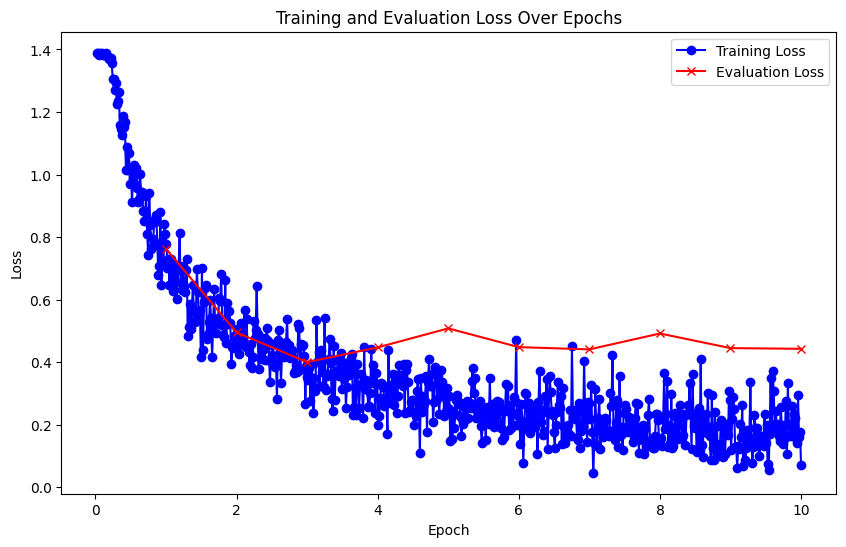

In [18]:
# Training data
train_epochs = [log['epoch'] for log in trainer.state.log_history if 'loss' in log]
train_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]

# Evaluation data
eval_epochs = [log['epoch'] for log in trainer.state.log_history if 'eval_loss' in log]
eval_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Aggregate evaluation loss to match training epochs (average for each epoch)
agg_eval_losses = []
epoch_start = 0

for epoch in range(1, len(train_epochs) + 1):
    # Find all evaluation losses that correspond to the current epoch
    epoch_end = epoch_start
    while epoch_end < len(eval_epochs) and eval_epochs[epoch_end] == epoch:
        epoch_end += 1
    
    # Calculate the average of evaluation losses for the current epoch
    epoch_losses = eval_losses[epoch_start:epoch_end]
    agg_eval_losses.append(np.mean(epoch_losses))
    
    # Update the index for the next epoch
    epoch_start = epoch_end

# Now we plot the training and aggregated evaluation loss
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(train_epochs, train_losses, label='Training Loss', color='blue', marker='o')

# Plot Aggregated Evaluation Loss
plt.plot(range(1, len(agg_eval_losses) + 1), agg_eval_losses, label='Evaluation Loss', color='red', marker='x')

# Set plot labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Epochs')

# Show legend
plt.legend()

# Display the plot
plt.show()

makes a heatmap

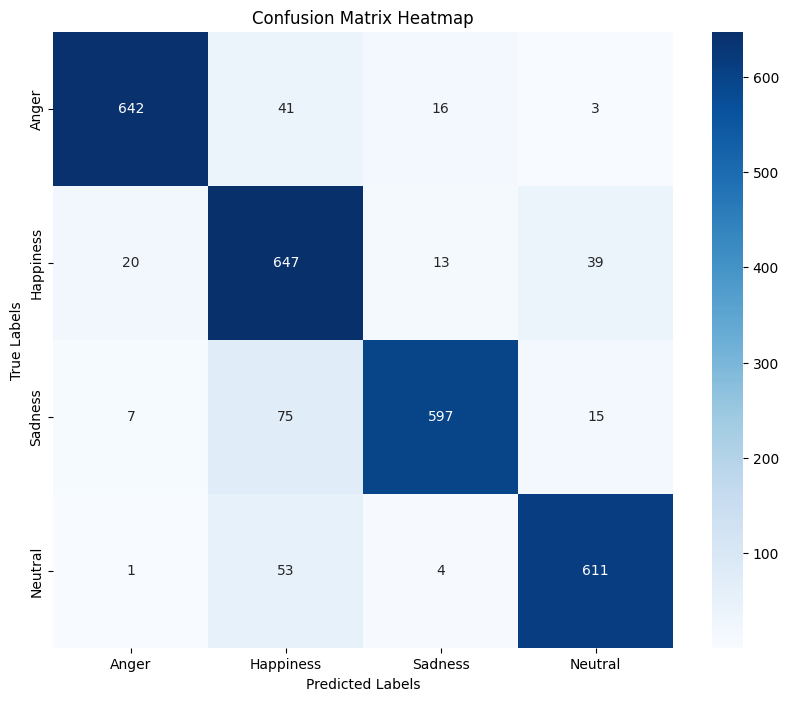

In [19]:
# Step 1: Make predictions on the test data
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)  # Get the predicted class labels

# Step 2: Get the true labels from the test dataset
y_true = test_dataset["label"]

# Step 3: Calculate confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Step 4: Plot the confusion matrix as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
